EDA

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class SupplyChainAnalysis:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        self.prepare_data()

    def prepare_data(self):
        """Clean and prepare the data for analysis"""

        date_cols = [col for col in self.df.columns if 'Date' in col]
        for col in date_cols:
            self.df[col] = pd.to_datetime(self.df[col], format='%d-%m-%Y %H:%M')

        self.df['Shipment.Shipping_Cost'] = self.df['Shipment.Shipping_Cost'].str.replace('$', '').str.replace(',', '').astype(float)
        self.df['Sales.Revenue'] = self.df['Sales.Revenue'].str.replace('$', '').str.replace(',', '').astype(float)

        self.df['Production_Lead_Time'] = (self.df['Production_order.Completion_Date'] - self.df['Production_order.Order_Date']).dt.days
        self.df['Delivery_Lead_Time'] = (self.df['Shipment.Delivery_Date'] - self.df['Shipment.Shipping_Date']).dt.days
        self.df['Total_Lead_Time'] = (self.df['Shipment.Delivery_Date'] - self.df['Production_order.Order_Date']).dt.days

    def supplier_analysis(self):
        """Analyze supplier performance"""
        supplier_metrics = self.df.groupby('Supplier_Name').agg({
            'Lead_Time_Days': ['mean', 'std'],
            'Quality_Rating': ['mean', 'std'],
            'Production_Lead_Time': 'mean',
            'Delivery_Lead_Time': 'mean',
            'Total_Lead_Time': 'mean'
        }).round(2)

        weights = {
            'Quality_Rating': 0.4,
            'Lead_Time_Days': 0.3,
            'Total_Lead_Time': 0.3
        }

        supplier_metrics['Supplier_Score'] = (
            supplier_metrics[('Quality_Rating', 'mean')] * weights['Quality_Rating'] +
            (1 / supplier_metrics[('Lead_Time_Days', 'mean')]) * weights['Lead_Time_Days'] +
            (1 / supplier_metrics[('Total_Lead_Time', 'mean')]) * weights['Total_Lead_Time']
        ).round(2)

        return supplier_metrics

    def inventory_analysis(self):
        """Analyze inventory levels and movements"""
        inventory_metrics = self.df.groupby('Inventory.Product_Name').agg({
            'Inventory.Quantity_Available': ['mean', 'min', 'max'],
            'Inventory.Reorder_Level': 'mean',
            'Sales.Quantity_Sold': 'sum',
            'Sales.Revenue': 'sum'
        }).round(2)

        inventory_metrics['Inventory_Turnover'] = (
            inventory_metrics[('Sales.Quantity_Sold', 'sum')] /
            inventory_metrics[('Inventory.Quantity_Available', 'mean')]
        ).round(2)

        return inventory_metrics

    def delivery_analysis(self):
        """Analyze delivery performance"""
        delivery_metrics = self.df.groupby('Shipment.Delivery_Status').agg({
            'Delivery_Lead_Time': ['count', 'mean', 'std'],
            'Shipment.Shipping_Cost': ['mean', 'sum']
        }).round(2)

        return delivery_metrics

    def plot_supplier_performance(self):
        """Create supplier performance visualization"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Quality Rating vs Lead Time', 'Supplier Scores',
                          'Lead Time Distribution', 'Quality Rating Distribution')
        )

        fig.add_trace(
            go.Scatter(
                x=self.df['Lead_Time_Days'],
                y=self.df['Quality_Rating'],
                mode='markers',
                text=self.df['Supplier_Name'],
                name='Suppliers'
            ),
            row=1, col=1
        )

        supplier_metrics = self.supplier_analysis()
        fig.add_trace(
            go.Bar(
                x=supplier_metrics.index,
                y=supplier_metrics['Supplier_Score'],
                name='Supplier Score'
            ),
            row=1, col=2
        )

        fig.add_trace(
            go.Histogram(
                x=self.df['Lead_Time_Days'],
                name='Lead Time'
            ),
            row=2, col=1
        )

        fig.add_trace(
            go.Histogram(
                x=self.df['Quality_Rating'],
                name='Quality'
            ),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="Supplier Performance Analysis")
        return fig

    def plot_inventory_status(self):
        """Create inventory status visualization"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Current Stock Levels', 'Stock vs Reorder Level',
                          'Inventory Turnover', 'Revenue by Product')
        )

        inventory_metrics = self.inventory_analysis()

        fig.add_trace(
            go.Bar(
                x=inventory_metrics.index,
                y=inventory_metrics[('Inventory.Quantity_Available', 'mean')],
                name='Current Stock'
            ),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(
                x=self.df['Inventory.Product_Name'].unique(),
                y=self.df.groupby('Inventory.Product_Name')['Inventory.Reorder_Level'].mean(),
                name='Reorder Level',
                mode='lines+markers'
            ),
            row=1, col=2
        )

        fig.add_trace(
            go.Bar(
                x=inventory_metrics.index,
                y=inventory_metrics['Inventory_Turnover'],
                name='Turnover Rate'
            ),
            row=2, col=1
        )

        fig.add_trace(
            go.Bar(
                x=inventory_metrics.index,
                y=inventory_metrics[('Sales.Revenue', 'sum')],
                name='Revenue'
            ),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="Inventory Analysis")
        return fig

    def generate_insights(self):
        """Generate key insights from the analysis"""
        supplier_metrics = self.supplier_analysis()
        inventory_metrics = self.inventory_analysis()
        delivery_metrics = self.delivery_analysis()

        insights = {
            'supplier_insights': {
                'best_supplier': supplier_metrics['Supplier_Score'].idxmax(),
                'worst_supplier': supplier_metrics['Supplier_Score'].idxmin(),
                'avg_lead_time': self.df['Lead_Time_Days'].mean(),
                'avg_quality': self.df['Quality_Rating'].mean()
            },
            'inventory_insights': {
                'high_turnover_products': inventory_metrics['Inventory_Turnover'].nlargest(3),
                'low_stock_products': inventory_metrics[
                    inventory_metrics[('Inventory.Quantity_Available', 'mean')] <
                    inventory_metrics[('Inventory.Reorder_Level', 'mean')]
                ].index.tolist()
            },
            'delivery_insights': {
                'avg_delivery_time': self.df['Delivery_Lead_Time'].mean(),
                'delivery_success_rate': (
                    self.df['Shipment.Delivery_Status'].value_counts(normalize=True)['Delivered'] * 100
                ).round(2)
            }
        }

        return insights

if __name__ == "__main__":

    analysis = SupplyChainAnalysis("/content/Final_data - Final_data.csv")

    insights = analysis.generate_insights()
    print("\nKey Insights:")
    print("-------------")
    print(f"Best Performing Supplier: {insights['supplier_insights']['best_supplier']}")
    print(f"Average Lead Time: {insights['supplier_insights']['avg_lead_time']:.2f} days")
    print(f"Delivery Success Rate: {insights['delivery_insights']['delivery_success_rate']}%")

    supplier_fig = analysis.plot_supplier_performance()
    inventory_fig = analysis.plot_inventory_status()

    supplier_fig.show()
    inventory_fig.show()


Key Insights:
-------------
Best Performing Supplier: SpeedyShip
Average Lead Time: 11.07 days
Delivery Success Rate: 39.13%


Delay to rating correlation

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply




Detailed Correlation Analysis by Supplier:
            Supplier  Correlation  Lead_Time_Mean  Quality_Rating_Mean
0         PharmaPlus          NaN            14.0                  4.3
1           PackWell          NaN             9.0                  4.5
2           ShipFast          NaN             7.0                  4.8
3         ChemHealth          NaN            11.0                  4.1
4    RawMaterialsHub          NaN            19.0                  4.4
5          QuickChem          NaN            13.0                  4.6
6         PackMakers          NaN            10.0                  4.7
7         SpeedyShip          NaN             8.0                  4.9
8         ChemSource          NaN            15.0                  4.2
9       EssentialMed          NaN            18.0                  4.5
10           ProChem          NaN            12.0                  4.6
11            PackIt          NaN             9.0                  4.4
12         QuickShip          NaN

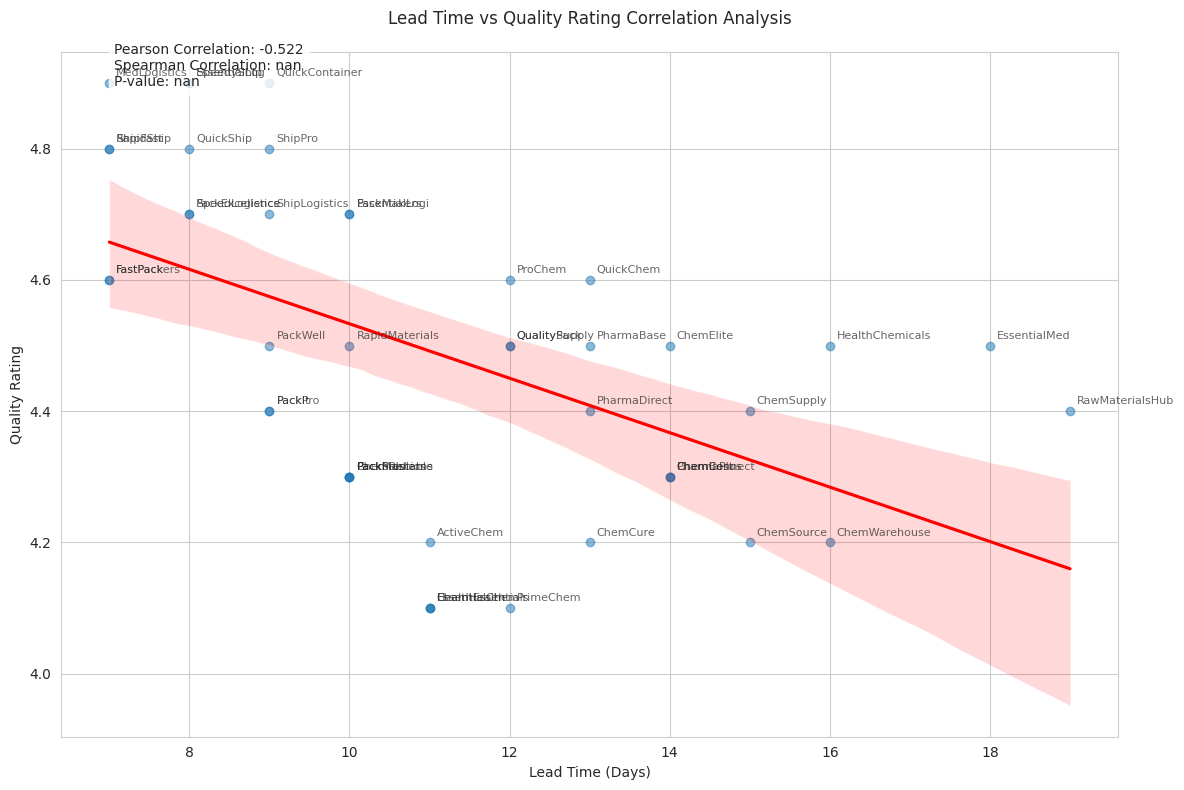

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def analyze_lead_time_quality_correlation(file_path):

    df = pd.read_csv(file_path)

    correlation = df['Lead_Time_Days'].corr(df['Quality_Rating'])

    spearman_corr, p_value = stats.spearmanr(df['Lead_Time_Days'], df['Quality_Rating'])

    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    sns.regplot(data=df, x='Lead_Time_Days', y='Quality_Rating',
                scatter_kws={'alpha':0.5},
                line_kws={'color': 'red'})

    plt.title('Lead Time vs Quality Rating Correlation Analysis', pad=20)
    plt.xlabel('Lead Time (Days)')
    plt.ylabel('Quality Rating')

    plt.text(0.05, 0.95, f'Pearson Correlation: {correlation:.3f}\n'
             f'Spearman Correlation: {spearman_corr:.3f}\n'
             f'P-value: {p_value:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    for i, row in df.iterrows():
        plt.annotate(row['Supplier_Name'],
                    (row['Lead_Time_Days'], row['Quality_Rating']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

    plt.tight_layout()
    return plt.gcf()

def detailed_correlation_analysis(df):
    supplier_metrics = df.groupby('Supplier_Name').agg({
        'Lead_Time_Days': ['mean', 'std'],
        'Quality_Rating': ['mean', 'std']
    }).round(3)

    correlations = []
    for supplier in df['Supplier_Name'].unique():
        supplier_data = df[df['Supplier_Name'] == supplier]
        corr = supplier_data['Lead_Time_Days'].corr(supplier_data['Quality_Rating'])
        correlations.append({
            'Supplier': supplier,
            'Correlation': corr,
            'Lead_Time_Mean': supplier_data['Lead_Time_Days'].mean(),
            'Quality_Rating_Mean': supplier_data['Quality_Rating'].mean()
        })

    return pd.DataFrame(correlations).sort_values('Correlation', ascending=False)

if __name__ == "__main__":
    df = pd.read_csv("/content/Final_data - Final_data.csv")

    correlation_plot = analyze_lead_time_quality_correlation("/content/Final_data - Final_data.csv")

    detailed_corr = detailed_correlation_analysis(df)
    print("\nDetailed Correlation Analysis by Supplier:")
    print(detailed_corr)

ML Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

class DataPreprocessor:
    def __init__(self):
        self.numeric_imputer = SimpleImputer(strategy='mean')
        self.categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.label_encoders = {}
        self.scaler = StandardScaler()

    def handle_missing_values(self, df):
        """Handle missing values in the dataset"""
       
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        categorical_cols = df.select_dtypes(include=['object']).columns

        df[numeric_cols] = self.numeric_imputer.fit_transform(df[numeric_cols])

        df[categorical_cols] = self.categorical_imputer.fit_transform(df[categorical_cols])

        return df

    def preprocess_data(self, df):
        """Preprocess the data including handling missing values and encoding"""
        print("Original shape:", df.shape)

        print("\nMissing values before handling:")
        print(df.isnull().sum()[df.isnull().sum() > 0])

        df = self.handle_missing_values(df)

        print("\nMissing values after handling:")
        print(df.isnull().sum()[df.isnull().sum() > 0])

        date_columns = [col for col in df.columns if 'Date' in col]
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], format='%d-%m-%Y %H:%M', dayfirst=True)
                df[f'{col}_month'] = df[col].dt.month
                df[f'{col}_day'] = df[col].dt.day
                df[f'{col}_dayofweek'] = df[col].dt.dayofweek

        df['Sales.Revenue'] = df['Sales.Revenue'].str.replace('$', '').str.replace(',', '').astype(float)
        df['Shipment.Shipping_Cost'] = df['Shipment.Shipping_Cost'].str.replace('$', '').str.replace(',', '').astype(float)

        df['Stock_Ratio'] = df['Inventory.Quantity_Available'] / df['Inventory.Reorder_Level']
        df['Production_Lead_Time'] = (df['Production_order.Completion_Date'] - df['Production_order.Order_Date']).dt.days
        df['Delivery_Lead_Time'] = (df['Shipment.Delivery_Date'] - df['Shipment.Shipping_Date']).dt.days
        df['Cost_per_Unit'] = df['Shipment.Shipping_Cost'] / df['Sales.Quantity_Sold'].replace(0, np.nan)
        df['Revenue_per_Unit'] = df['Sales.Revenue'] / df['Sales.Quantity_Sold'].replace(0, np.nan)

        return df

class DemandPredictionModel:
    def __init__(self):
        self.preprocessor = DataPreprocessor()
        self.model = None

    def prepare_features(self, df):
        """Prepare features for demand prediction"""
  
        df = self.preprocessor.preprocess_data(df)

        selected_features = [
        
            'Inventory.Quantity_Available',
            'Inventory.Reorder_Level',
            'Stock_Ratio',

            'Lead_Time_Days',
            'Quality_Rating',
            'Production_Lead_Time',
            'Delivery_Lead_Time',

            'Cost_per_Unit',
            'Revenue_per_Unit',

            'Sales.Sale_Date_month',
            'Sales.Sale_Date_dayofweek',

            'Feedback.Customer_Rating'
        ]

        categorical_features = [
            'Inventory.Product_Name',
            'Material_Type',
            'Sales.Region',
            'Inventory.Warehouse_Location'
        ]

        for feature in categorical_features:
            le = LabelEncoder()
            df[f'{feature}_encoded'] = le.fit_transform(df[feature])
            selected_features.append(f'{feature}_encoded')

        X = df[selected_features]
        y = df['Sales.Quantity_Sold']

        X_scaled = self.preprocessor.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

        return X_scaled, y

    def train_model(self, X, y):
        """Train and evaluate the model"""

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                random_state=42
            ),
            'XGBoost': xgb.XGBRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            )
        }

        results = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            results[name] = {
                'r2_score': r2_score(y_test, predictions),
                'rmse': np.sqrt(mean_squared_error(y_test, predictions)),
                'feature_importance': pd.DataFrame({
                    'feature': X.columns,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
            }

        best_model = max(results.items(), key=lambda x: x[1]['r2_score'])
        self.model = models[best_model[0]]

        return results

if __name__ == "__main__":

    print("Loading data...")
    df = pd.read_csv("/content/Final_data - Final_data.csv")

    model = DemandPredictionModel()

    print("\nPreparing features...")
    X, y = model.prepare_features(df)

    print("\nTraining models...")
    results = model.train_model(X, y)

    print("\nModel Results:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print(f"R2 Score: {metrics['r2_score']:.3f}")
        print(f"RMSE: {metrics['rmse']:.3f}")
        print("\nTop 10 Most Important Features:")
        print(metrics['feature_importance'].head(10))

Loading data...

Preparing features...
Original shape: (46, 30)

Missing values before handling:
Supplier_ID                          1
Supplier_Name                        1
Lead_Time_Days                       1
Quality_Rating                       1
Location                             1
Material_Type                        1
Inventory.Product_ID                 1
Inventory.Product_Name               1
Inventory.Quantity_Available         1
Inventory.Reorder_Level              1
Inventory.Warehouse_Location         1
Production_order.Order_ID            1
Production_order.Quantity_Ordered    1
Production_order.Order_Date          1
Production_order.Completion_Date     1
Production_order.Status              1
Sales.Sale_ID                        1
Sales.Sale_Date                      1
Sales.Quantity_Sold                  1
Sales.Revenue                        1
Sales.Region                         1
Feedback.Feedback_ID                 1
Feedback.Customer_Rating             1
Feedba